In [1]:
import matplotlib.pyplot as plt

# Elementos de matriz y funciones personalizadas
from H2.elementos_matriz import *
from H2.graficar import graficar_elementos_matriz, graficar_RHF

# Energía de la molécula de hidrógeno $\mathrm{H}_2$
---

## Elementos de matriz

Dado que el cálculo de las energías $E_1^\text{RHF}$, $E_2^\text{RHF}$ y $E_1^\text{UHF}$ dependen de los mismos elementos de matriz, se calcularán todos los elementos de matriz para un rango de distancias interatómicas y posteriormente estos serán consultados para la determinación de la energía.

In [2]:
# Energía del átomo de hidrógeno en la base STO-3G
RB: NDArray = np.array([1000000, 0, 0])
EH_STO3G: float = fpp(1, d, a, RA, RB, ZA, ZB)
print("Energía hidrógeno:", EH_STO3G)

Energía hidrógeno: -0.4665910279627299


In [3]:
# cargar elementos de matriz previamente calculados
R, h11, h22, J11, J22, J12, K12, hnuc = elementos_H2('cargar', 'H2_STO3G')

# calculo (y guardado) de elementos de matriz para diferentes distancias internucleares en un intervalo
# intervalo = [0.15, 15.06, 0.05]
# R, h11, h22, J11, J22, J12, K12, hnuc = elementos_H2('calcular', intervalo)

Elementos de matriz y distancias interatómicas cargadas.


In [4]:
guardar_img: bool = False

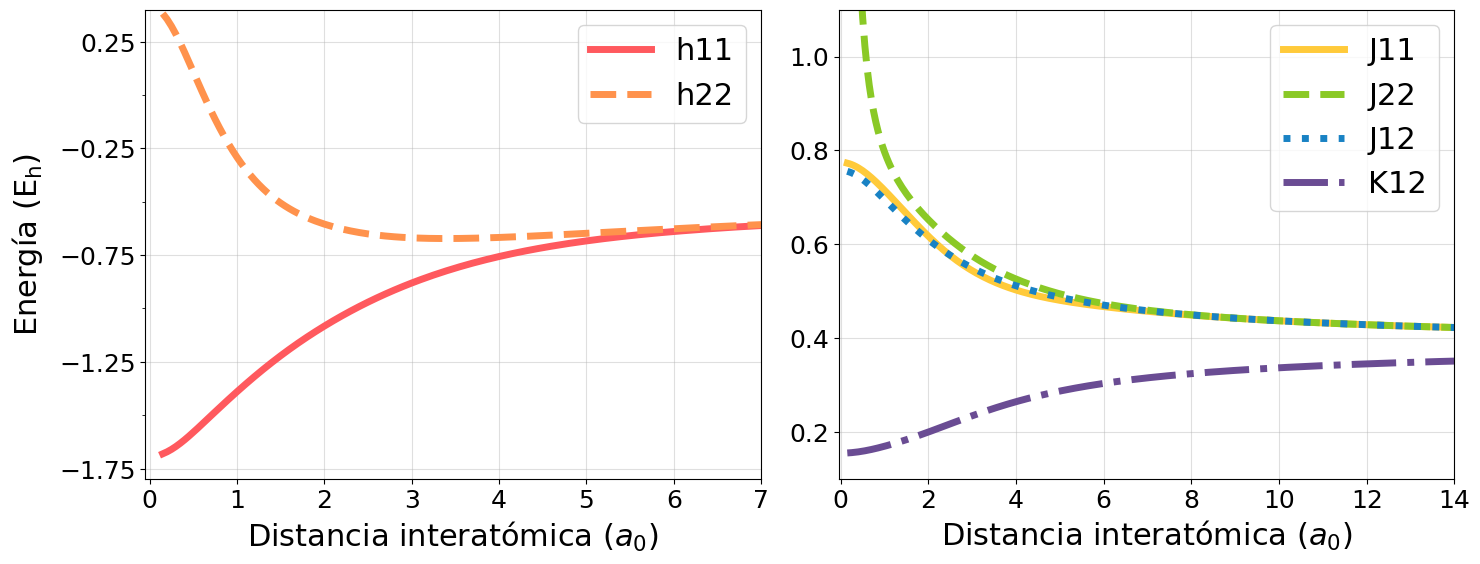

In [5]:
# Graficar elementos de matriz
linewidth, fontsize, labelsize, alpha = 5, 22, 18, 0.4
elementos = [h11, h22, J11, J22, J12, K12]
opciones = [linewidth, fontsize, labelsize, alpha]
nombre = 'H2_STO3G_elementos_matriz'

graficar_elementos_matriz(R, elementos, opciones, guardar_img, nombre)

Las integrales de dos cuerpos tienden todas al mismo valor cuando la separación interatómica se vuelve infinita. Si bien para la integral $K_{12}$ no se logra apreciar esto aún a una distancia de $14a_0$ se puede apreciar calculando numéricamente el valor que tomaría para $R \to \infty$.

In [6]:
g1212, g3434, g1313, g1331 = dos_cuerpos(d, a, RA, RB, ZA, ZB)
print("--- Integrales de dos cuerpos para R -> ∞ ---")
print("J11:", g1212)
print("J22:", g3434)
print("J12:", g1313)
print("K12:", g1331)

--- Integrales de dos cuerpos para R -> ∞ ---
J11: 0.3873044805308669
J22: 0.3873044805308669
J12: 0.3873044805308669
K12: 0.38730348052939195


## Hartree-Fock Restringido (RHF)

La función de onda RHF para el estado base y el doblemente excitado son

$$\Psi_1^\text{RHF} = \ket{\chi_1 \bar{\chi}_1} \,,$$
$$\Psi_2^\text{RHF} = \ket{\chi_2 \bar{\chi}_2}\,.$$

Cuyas energías asociadas son

$$E_1^\text{RHF} = 2h_{11} + J_{11} + h_\text{nuc} \,,$$

$$E_2^\text{RHF} = 2h_{22} + J_{22} + h_\text{nuc} \,.$$

In [7]:
RHF1: NDArray = 2*h11 + J11 + hnuc # energía restringida (orbital ligante)
RHF2: NDArray = 2*h22 + J22 + hnuc # energía restringida (orbital antiligante)

# guardar valores para la energía
# (descomentar en caso de generar nuevos elementos de matriz)
guardar('H2_STO3G_RHF1', RHF1)
guardar('H2_STO3G_RHF2', RHF2)

In [ ]:
guardar_img: bool = True

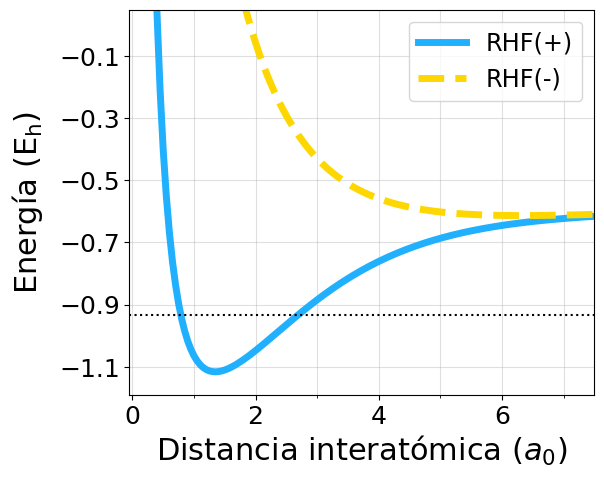

In [8]:
# Graficar energías RHF+ y RHF-
y: list[NDArray] = [RHF1, RHF2]
linewidth, fontsize, labelsize, alpha = 5, 22, 18, 0.4
opciones: list = [linewidth, fontsize, labelsize, alpha]

graficar_RHF(R, y, EH_STO3G, opciones, guardar_img)

---
## Hartree-Fock sin restricción (UHF)

$$\eta_1 = \cos2\theta_1 =  \frac{E_2^\text{RHF} - E_1^\text{RHF}}{J_{11} + J_{22} - 2J_{12} + 4K_{12}}$$

$$\eta_2 = \cos2\theta_2 =  \frac{E_1^\text{RHF} - E_2^\text{RHF}}{J_{11} + J_{22} - 2J_{12} + 4K_{12}} = -\eta_1$$

In [9]:
def E_UHF(orbital: str, i: int) -> list[float]:
    """ Cálculo de la energía no restringida (UHF)
    
    Parámetros:
        orbital: 'ligante' o 'antiligante' (en t=0)
        i: índice de la lista
    """

    eta1: float = (RHF2[i] - RHF1[i]) / (J11[i] + J22[i] - 2*J12[i] + 4*K12[i]) # eta del caso ligante
    if orbital == 'ligante': # caso ligante
        eta: float = eta1
        theta: int | float = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
    else: # caso antiligante
        eta: float = -eta1
        theta: int | float = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
    
    cos: float = np.cos(theta)
    sin: float = np.sin(theta)

    if orbital == 'ligante':
        E1: float = 2*h11[i]*np.power(cos,2) + 2*h22[i]*np.power(sin,2)
        E2: float = J11[i]*np.power(cos,4) + J22[i]*np.power(sin,4) 
    else:
        E1: float = 2*h11[i]*np.power(sin,2) + 2*h22[i]*np.power(cos,2)
        E2: float = J11[i]*np.power(sin,4) + J22[i]*np.power(cos,4)

    E3: float = (2*J12[i]-4*K12[i])*np.power(cos,2)*np.power(sin,2)
    Etot: float = E1 + E2 + E3 + hnuc[i] # energía total
    
    return  Etot, theta, eta

In [10]:
ang1, eta1 = [], [] # lista de ángulos para cada distancia internuclear
ang2, eta2 = [], [] # lista de ángulos para cada distancia internuclear

UHF1: list[float] = [] # energías UHF, orbital ligante en t=0
UHF2: list[float] = [] # energías UHF, orbital antiligante en t=0
for i in range(len(R)):
    # caso orbital lignante en t=0
    energia1, theta1, eta = E_UHF('ligante', i)
    UHF1.append(energia1)
    ang1.append(theta1)
    eta1.append(eta)
    # caso orbital antiligante en t=0
    energia2, theta2, eta = E_UHF('antiligante', i)
    UHF2.append(energia2)
    ang2.append(theta2)
    eta2.append(eta)

# Descomentar líneas siguientes si hay cambios
# guardar('H2_STO3G_UHF1', UHF1)
# guardar('H2_STO3G_UHF2', UHF2)

In [11]:
# índice del primer ángulo diferente de cero/NaN, RHF
index = next((i for i, x in enumerate(ang1) if x), None)
x0, y0 = R[index], UHF1[index]
x_ang, y_ang = R[index], ang1[index]

print("--- Coord. donde UHF y RHF dejan de ser iguales ---")
print("Distancia:", x0)
print("Energía:", y0)

--- Coord. donde UHF y RHF dejan de ser iguales ---
Distancia: 2.2
Energía: -1.0154782413729193


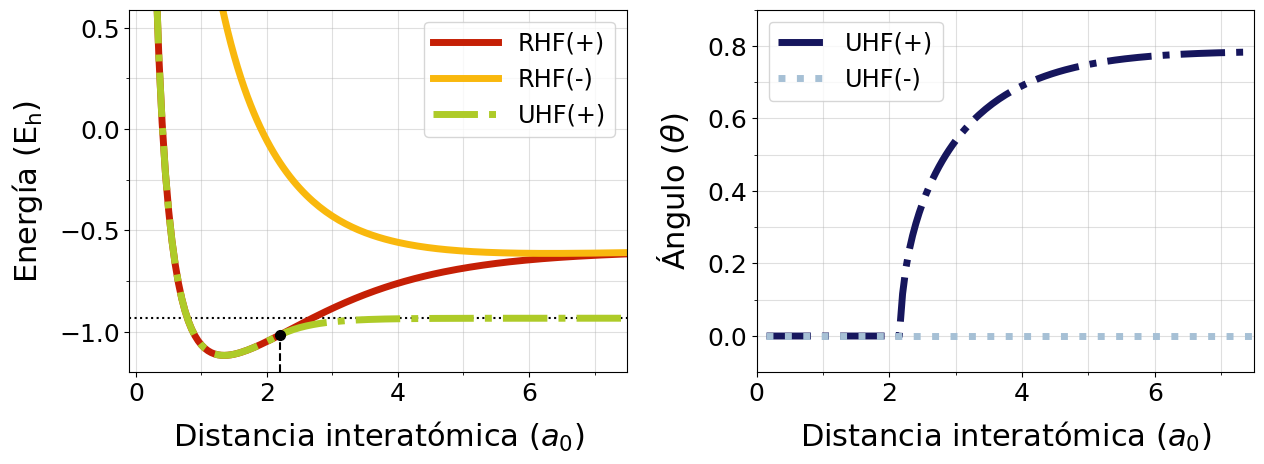

In [12]:
# Graficar energía UHF

fig, axs = plt.subplots(1, 2, figsize=(13, 5))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize, labelsize, alpha = 5, 22, 18, 0.4

###################
### Gráfica derecha
###################
xmin, xmax = -0.1, 7.5
ymin, ymax = -1.2, 0.59

axs[0].axhline(y = 2*EH_STO3G, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)
axs[0].plot(R, RHF1, label='RHF(+)', linestyle='solid', linewidth=linewidth, color='#c51f05') # energías RHF orbital ligante
axs[0].plot(R[3:], RHF2[3:], label='RHF(-)', linestyle='solid', linewidth=linewidth, color='#f9b80d') # energías RHF orbital antiligante
axs[0].plot(R, UHF1, label='UHF(+)', linestyle='dashdot', linewidth=linewidth, color='#aecb28') # energías UHF(+)
# axs[0].plot(R, UHF2, label='UHF(-)', linestyle='dotted', linewidth=width, color='#006d66') # energías UHF(-)

axs[0].vlines(x=x0, ymin=ymin, ymax=y0, color='black', linestyle='dashed')
axs[0].plot(x0, y0, ls="", marker="o", color='black', markersize=7) # punto a partir de donde RHF y UHF ya no son iguales

# x config
axs[0].set_xlim(xmin, xmax)
axs[0].set_xlabel('Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
axs[0].set_xticks(np.arange(0, xmax, 2))
axs[0].set_xticks(np.arange(0, xmax, 1), minor=True)
# y config
axs[0].set_ylim(ymin, ymax)
axs[0].set_ylabel(r'Energía ($\text{E}_\text{h}$)', fontsize=fontsize, labelpad=10)
axs[0].set_yticks(np.arange(-1, ymax, 0.50))
axs[0].set_yticks(np.arange(-1, ymax, 0.25), minor=True)
# plot config
axs[0].legend(fontsize='xx-large', handlelength=2.7)
axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[0].grid(alpha=alpha, which='both')

#####################
### Gráfica izquierda
#####################
xmin, xmax = 0, 7.5
ymin, ymax = -0.1, 0.9

axs[1].plot(R, ang1, label='UHF(+)', linestyle='dashdot', linewidth=linewidth, color='#16165d') # energías UHF
axs[1].plot(R, ang2, label='UHF(-)', linestyle='dotted', linewidth=linewidth, color='#a6c0d5') # energías UHF
# x config
axs[1].set_xlim(xmin, xmax)
axs[1].set_xlabel('Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
axs[1].set_xticks(np.arange(xmin, xmax, 2))
axs[1].set_xticks(np.arange(xmin, xmax, 1), minor=True)
# y config
axs[1].set_ylim(ymin, ymax)
axs[1].set_ylabel(r'Ángulo ($\theta$)', fontsize=fontsize, labelpad=10)
axs[1].set_yticks(np.arange(0, 1, 0.2))
axs[1].set_yticks(np.arange(0, 1, 0.1), minor=True)
# plot config
axs[1].legend(fontsize='xx-large')
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].grid(alpha=alpha, which='both')

fig.tight_layout(pad=2)
plt.show()
fig.savefig('imgs/H2_STO3G_RHFvsUHF.svg', format='svg', bbox_inches='tight')

---
## Interacción de configuraciones CI

La función de onda CI es

$$\ket{\Phi_0} = c_0 \ket{\Psi_0} + c_{12}^{34} \ket{\Psi_{12}^{34}} \,.$$

donde
$$\ket{\Psi_0} = \ket{\chi_1 \chi_2} \qquad \text{y} \qquad \ket{\Psi_{12}^{34}} = \ket{\chi_3 \chi_4} \,.$$

La matriz de configuración de interacción es

$$
\mathbf{H} =
\begin{pmatrix}
    \langle \Psi_0 | \mathcal{H}_\mathrm{el} | \Psi_0 \rangle
        & \langle \Psi_0 | \mathcal{H}_\mathrm{el} | \Psi_{12}^{34} \rangle \\
    \langle \Psi_{12}^{34} | \mathcal{H}_\mathrm{el} | \Psi_0 \rangle
        & \langle \Psi_{12}^{34} | \mathcal{H}_\mathrm{el} | \Psi_{12}^{34} \rangle \\
\end{pmatrix} =
\begin{pmatrix}
    2h_{11} + J_{11} & K_{12} \\
    K_{12} & 2h_{22} + J_{22} \\
\end{pmatrix}
+ \mathbb{1} h_\mathrm{nuc}
$$

Los eigenvalores resultantes de diagonalizar la matriz $\mathbf{H}$ es
$$ E_{\pm} = \frac{H_{11} + H_{22} \pm \sqrt{(H_{11} - H_{22})^2 + 4|H_{12}|^2}}{2}
= \frac{1}{2} (H_{11} + H_{22} \pm \sqrt{\Delta}) \,.$$

In [13]:
# elementos de la matriz de configuración
H11: NDArray = RHF1
H22: NDArray = RHF2
H12: NDArray = K12

# energías asociadas a la diagonalización
delta: NDArray = np.square(H11-H22) + 4*np.square(H12) # discriminante
E1: NDArray = (H11 + H22 - np.sqrt(delta))/ 2 # E- (caso base)
E2: NDArray = (H11 + H22 + np.sqrt(delta))/ 2 # E+ (caso excitado)

El eigenvector $\mathbf{c}_\pm$ asociado a la energía $E_\pm$ es $\mathbf{c} = (c_0^\pm, c_1^\pm)^T$ donde

$$ c_0^\pm \equiv \frac{H_{12}}{\sqrt{| E_{\pm} - H_{11}|^2 + |H_{12}|^2}} \,,$$

$$ c_1^\pm \equiv \frac{E_{\pm} - H_{11}}{\sqrt{|E_{\pm} - H_{11}|^2 + |H_{12}|^2}} \,.$$

In [14]:
# Cálculo de coeficientes c1 y c2

# coefs. asociados a E1 (E-)
den1: NDArray = np.sqrt(np.square(E1 - H11) + np.square(H12))
c10: NDArray = H12 / den1
c11: NDArray = (E1 - H11) / den1

# coefs. asociados a E2 (E+)
den2: NDArray = np.sqrt(np.square(E2 - H11) + np.square(H12))
c20: NDArray = H12 / den2
c21: NDArray = (E2 - H11) / den2

CI1: NDArray = np.square(c10)*RHF1 + np.square(c11)*RHF2 + 2*c10*c11*H12 # energía CI asociada a E1 (estado base)
CI2: NDArray = np.square(c20)*RHF1 + np.square(c21)*RHF2 + 2*c20*c21*H12 # energía CI asociada a E2

# guardar valores
guardar('H2_STO3G_CI1', CI1)
guardar('H2_STO3G_CI2', CI2)

**Wolniewicz**

Como punto de comparación se emplearán los valores de la energía provistos por L. Wolniewicz en 1995 [1].

In [15]:
# distancias interatomicas
R_Wolniewicz: NDArray = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 4.0, 4.5, 5.0, 6.0, 8.0])

# Energía (radios de Bohr)
E_Wolniewicz: NDArray = np.array([-0.769635427887, -1.020056664330, -1.124539718008, -1.164935241876, 
                                      -1.174475713565, -1.168583371916, -1.155068736046, -1.138132955488, 
                                      -1.120132112181, -1.102422601703, -1.085791233366, -1.070683223812, 
                                      -1.057326265285, -1.045799653502, -1.016390251364, -1.007993728135, 
                                      -1.003785657939, -1.000835707231, -1.000055604837])

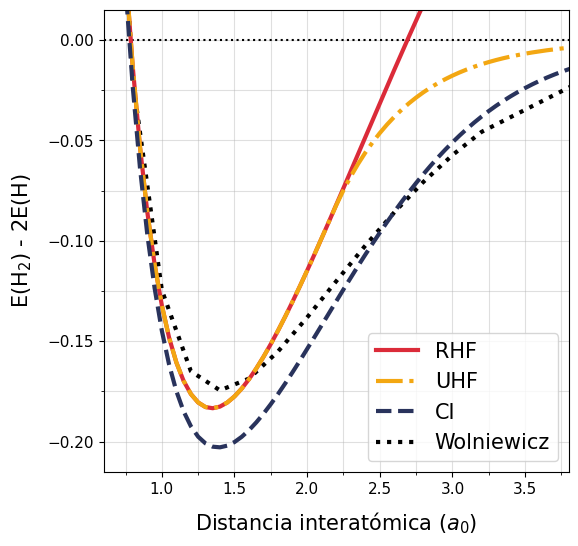

In [16]:
# Graficar energía CI

fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize, labelsize, alpha = 3, 15, 11, 0.4

ax.axhline(0, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)
ax.plot(R_Wolniewicz, E_Wolniewicz-2*(-0.5), linewidth=3, linestyle='dotted', label='Wolniewicz', color='black')
ax.plot(R, RHF1-2*EH_STO3G, linewidth=linewidth, linestyle='solid', label='RHF', color='#db2b39')
ax.plot(R, UHF1-2*EH_STO3G, linewidth=linewidth, linestyle='dashdot', label='UHF', color='#f3a712')
ax.plot(R, CI1-2*EH_STO3G, linewidth=linewidth, linestyle='dashed', label='CI', color='#29335c')

# x config
xmin, xmax = 0.6, 3.8
ax.set_xticks(np.arange(0, xmax, 0.5))
ax.set_xticks(np.arange(0, xmax, 0.25), minor=True)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
# y config
ymin, ymax = -0.215, 0.015
ax.set_yticks(np.arange(-0.3, ymax, 0.05))
ax.set_yticks(np.arange(-0.3, ymax, 0.025), minor=True)
ax.set_ylim(ymin, ymax)
ax.set_ylabel(r'E(H$_2$) - 2E(H)', fontsize=fontsize, labelpad=10)
# plot configplt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
handles, labels = ax.get_legend_handles_labels()
order = [1,2,3,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fontsize)
ax.grid(alpha=alpha, which='both')
ax.tick_params(axis='both', which='major', labelsize=labelsize)

# fig.tight_layout(pad=1)
plt.show()
# fig.savefig('imgs/H2_STO3G_CI.svg', format='svg', bbox_inches='tight')

---
## Punto de control

Aquí se calculan todas las energías en cuestión para una distancia interatómica de $R = 1.4a_0$ .

In [17]:
RB: NDArray = np.array([1.4, 0, 0])
hnuc: float = 1/(np.linalg.norm(RA-RB))
h11, h22, J11, J22, J12, K12 = elementos_matriz(d, a, RA, RB, ZA, ZB)

In [18]:
RHF1 = 2*h11 + J11 + hnuc
RHF2 = 2*h22 + J22 + hnuc
print("--- Energías restringidas (R=1.4a0) ---")
print("RHF (ligante):", RHF1)
print("RHF (antiligante):", RHF2)

--- Energías restringidas (R=1.4a0) ---
RHF (ligante): -1.1157287495398318
RHF (antiligante): 0.48439549607543997


In [19]:
eta = (RHF2 - RHF1) / (J11 + J22 - 2*J12 + 4*K12) # eta del caso ligante
theta = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
cos = np.cos(theta)
sin = np.sin(theta)

E1 = 2*h11*np.power(cos,2) + 2*h22*np.power(sin,2)
E2 = J11*np.power(cos,4) + J22*np.power(sin,4)
E3 = (2*J12-4*K12)*np.power(cos,2)*np.power(sin,2)
UHF = E1 + E2 + E3 + hnuc # energía total

print("--- Energía no restringida (R=1.4a0) ---")
print("UHF (ligante):", UHF)

--- Energía no restringida (R=1.4a0) ---
UHF (ligante): -1.1157287495398318


In [20]:
# elementos de la matriz de configuración
H11 = RHF1
H22 = RHF2
H12 = K12

# energías asociadas a la diagonalización
delta = np.square(H11-H22) + 4*np.square(H12) # discriminante
E1 = (H11 + H22 - np.sqrt(delta))/ 2 # E- (caso base)
E2 = (H11 + H22 + np.sqrt(delta))/ 2 # E+ (caso excitado)

# Cálculo de coeficientes c1 y c2

# coefs. asociados a E-
denM = np.sqrt(np.square(E1 - H11) + np.square(H12))
c0 = H12 / denM
c1 = (E1 - H11) / denM

CI = np.square(c0)*RHF1 + np.square(c1)*RHF2 + 2*c0*c1*H12

print("--- Energía CI (R=1.4a0) ---")
print("CI (estado base):", CI)

--- Energía CI (R=1.4a0) ---
CI (estado base): -1.1360042137264037


---
# Referencias
[1] Wolniewicz, L. (1995). Nonadiabatic energies of the ground state of the hydrogen molecule. The Journal of Chemical Physics, 103(5), 1792–1799. doi:10.1063/1.469753 